In [34]:
import numpy as np
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import os
import treecorr
import h5py

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/chihway/.conda/envs/shear_decade/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [35]:
# psf_files = os.listdir('/project/chihway/data/decade/psf_cats')
psf_files = os.listdir('/project2/chihway/secco/PSFs/Nov2022/r')

In [36]:
# !!! Need to add other bands for the PSF !!!

In [37]:
T = []
T_mod = []
e1 = []
e1_mod = []
e2 = []
e2_mod = []
ra = []
dec = []
snr = []


for ff in psf_files:
    infile = pf.open('/project2/chihway/secco/PSFs/Nov2022/r/'+ff)[1].data
    mask = (infile['IMAFLAGS_ISO']==0)
    T.append(infile['T_star_hsm'][mask])
    T_mod.append(infile['T_model_hsm'][mask])
    e1.append(infile['g1_star_hsm'][mask])
    e1_mod.append(infile['g1_model_hsm'][mask])
    e2.append(infile['g2_star_hsm'][mask])
    e2_mod.append(infile['g2_model_hsm'][mask])
    ra.append(infile['ra'][mask])
    dec.append(infile['dec'][mask])
    snr.append(infile['FLUX_APER_8'][mask]/infile['FLUXERR_APER_8'][mask])
    

/tmp/ipykernel_38080/840614605.py:23: RuntimeWarning: invalid value encountered in true_divide
  snr.append(infile['FLUX_APER_8'][mask]/infile['FLUXERR_APER_8'][mask])


In [38]:
T = np.hstack(np.array(T))
T_mod = np.hstack(np.array(T_mod))
e1 = np.hstack(np.array(e1))
e1_mod = np.hstack(np.array(e1_mod))
e2 = np.hstack(np.array(e2))
e2_mod = np.hstack(np.array(e2_mod))
ra = np.hstack(np.array(ra))
dec = np.hstack(np.array(dec))
snr = np.hstack(np.array(snr))

/tmp/ipykernel_38080/3551877762.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T = np.hstack(np.array(T))
/tmp/ipykernel_38080/3551877762.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T_mod = np.hstack(np.array(T_mod))
/tmp/ipykernel_38080/3551877762.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  e1 = np.hstack(np.ar

In [39]:
d_e1_psf = e1-e1_mod
d_e2_psf = e2-e2_mod
d_T1_psf = e1*(T-T_mod)/T
d_T2_psf = e2*(T-T_mod)/T


d_e1_psf = np.nan_to_num(d_e1_psf)
d_e2_psf = np.nan_to_num(d_e2_psf)
d_T1_psf = np.nan_to_num(d_T1_psf)
d_T2_psf = np.nan_to_num(d_T2_psf)

mask = (d_e1_psf!=0)*(d_e2_psf!=0)*(d_T1_psf!=0)*(d_T2_psf!=0)*(snr>40)

d_e1_psf = d_e1_psf[mask]
d_e2_psf = d_e2_psf[mask]
ra_psf = ra[mask]
dec_psf = dec[mask]
snr_psf = snr[mask]
e1_star = e1[mask]
e2_star = e2[mask]
e1_psf = e1_mod[mask]
e2_psf = e2_mod[mask]
w1 = d_T1_psf[mask]
w2 = d_T1_psf[mask]

In [40]:
with h5py.File('/project2/chihway/data/decade/metacal_test_1000tiles_20221108_all.hdf') as f:

    mask0 = (~((f['DATA/mcal_T_noshear'][:]>2)*(f['DATA/mcal_s2n_noshear'][:]<30)))*(f['DATA/mcal_T_noshear'][:]<10)*(f['DATA/mcal_s2n_noshear'][:]<1000)*(f['DATA/mcal_s2n_noshear'][:]>10)*(f['DATA/mcal_T_ratio_noshear'][:]>0.5)

    ra_gal = f['DATA/ra'][mask0]
    dec_gal = f['DATA/dec'][mask0]
    g1_gal = f['DATA/mcal_g_noshear'][:,0][mask0]/0.71 # average calibration
    g2_gal = f['DATA/mcal_g_noshear'][:,1][mask0]/0.71
    

In [43]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf, npatch=100)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, patch_centers=cat_psf.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
cov_jk = gg.estimate_cov('jackknife')
theta = np.exp(gg.meanlogr)

tau2p = gg.xip
tau2m = gg.xim
tau2p_err = np.diag(cov_jk)[:20]**0.5 #gg.varxip**0.5
tau2m_err = np.diag(cov_jk)[20:]**0.5 #gg.varxim**0.5
tau2_cov = cov_jk

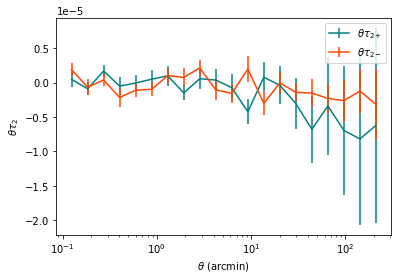

In [44]:
mplot.errorbar(theta, theta*tau2p, theta*tau2p_err, color='teal', label='$\\theta \\tau_{2+}$')
mplot.errorbar(theta, theta*tau2m, theta*tau2m_err, color='orangered', label='$\\theta \\tau_{2-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{2}$')
mplot.legend()

In [45]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf, npatch=100)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, patch_centers=cat_psf.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
cov_jk = gg.estimate_cov('jackknife')
theta = np.exp(gg.meanlogr)

tau0p = gg.xip
tau0m = gg.xim
tau0p_err = np.diag(cov_jk)[:20]**0.5 #gg.varxip**0.5
tau0m_err = np.diag(cov_jk)[20:]**0.5 #gg.varxim**0.5
tau0_cov = cov_jk


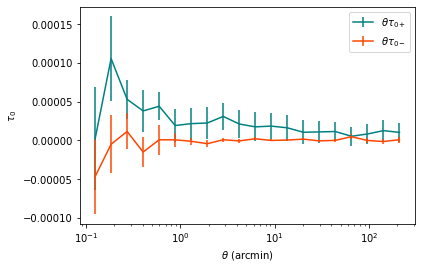

In [46]:
mplot.errorbar(theta, tau0p, tau0p_err, color='teal', label='$\\theta \\tau_{0+}$')
mplot.errorbar(theta, tau0m, tau0m_err, color='orangered', label='$\\theta \\tau_{0-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ \\tau_{0}$')
mplot.legend()

In [47]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2, npatch=100)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, patch_centers=cat_psf.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
cov_jk = gg.estimate_cov('jackknife')
theta = np.exp(gg.meanlogr)

tau5p = gg.xip
tau5m = gg.xim
tau5p_err = np.diag(cov_jk)[:20]**0.5 #gg.varxip**0.5
tau5m_err = np.diag(cov_jk)[20:]**0.5 #gg.varxim**0.5
tau5_cov = cov_jk


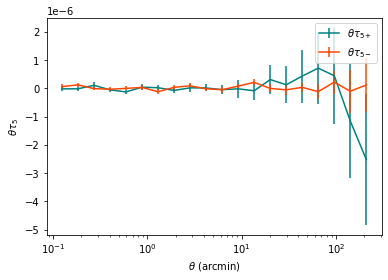

In [48]:
mplot.errorbar(theta, theta*tau5p, theta*tau5p_err, color='teal', label='$\\theta \\tau_{5+}$')
mplot.errorbar(theta, theta*tau5m, theta*tau5m_err, color='orangered', label='$\\theta \\tau_{5-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{5}$')
mplot.legend()

## Also calculate the rho stats to get alpha beta gamma

In [49]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
theta = np.exp(gg.meanlogr)

rho0p = gg.xip
rho0m = gg.xim
rho0p_err = gg.varxip**0.5
rho0m_err = gg.varxim**0.5


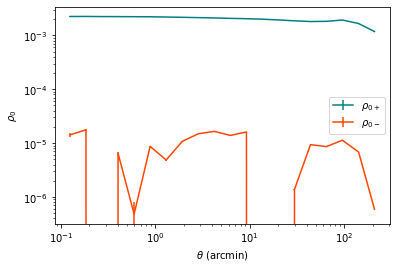

In [50]:
mplot.errorbar(theta, rho0p, rho0p_err, color='teal', label='$ \\rho_{0+}$')
mplot.errorbar(theta, rho0m, rho0m_err, color='orangered', label='$ \\rho_{0-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ \\rho_{0}$')
mplot.legend()

In [51]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
theta = np.exp(gg.meanlogr)

rho1p = gg.xip
rho1m = gg.xim
rho1p_err = gg.varxip**0.5
rho1m_err = gg.varxim**0.5


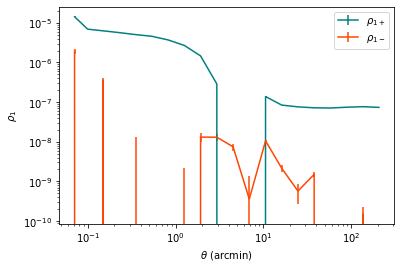

In [52]:
mplot.errorbar(theta, rho1p, rho1p_err, color='teal', label='$ \\rho_{1+}$')
mplot.errorbar(theta, rho1m, rho1m_err, color='orangered', label='$ \\rho_{1-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ \\rho_{1}$')
mplot.legend()

In [53]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
theta = np.exp(gg.meanlogr)

rho2p = gg.xip
rho2m = gg.xim
rho2p_err = gg.varxip**0.5
rho2m_err = gg.varxim**0.5


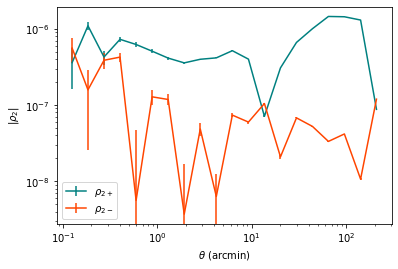

In [54]:
mplot.errorbar(theta, np.abs(rho2p), rho2p_err, color='teal', label='$ \\rho_{2+}$')
mplot.errorbar(theta, np.abs(rho2m), rho2m_err, color='orangered', label='$ \\rho_{2-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ |\\rho_{2}|$')
mplot.legend()

In [55]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
theta = np.exp(gg.meanlogr)

rho3p = gg.xip
rho3m = gg.xim
rho3p_err = gg.varxip**0.5
rho3m_err = gg.varxim**0.5


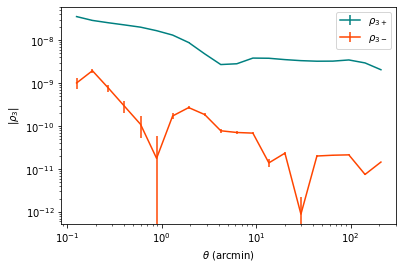

In [56]:
mplot.errorbar(theta, np.abs(rho3p), rho3p_err, color='teal', label='$ \\rho_{3+}$')
mplot.errorbar(theta, np.abs(rho3m), rho3m_err, color='orangered', label='$\\rho_{3-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ |\\rho_{3}|$')
mplot.legend()

In [57]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)

gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
theta = np.exp(gg.meanlogr)

rho4p = gg.xip
rho4m = gg.xim
rho4p_err = gg.varxip**0.5
rho4m_err = gg.varxim**0.5


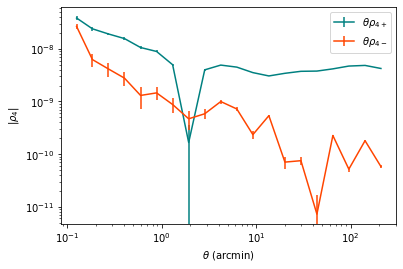

In [58]:
mplot.errorbar(theta, np.abs(rho4p), rho4p_err, color='teal', label='$\\theta \\rho_{4+}$')
mplot.errorbar(theta, np.abs(rho4m), rho4m_err, color='orangered', label='$\\theta \\rho_{4-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$|\\rho_{4}|$')
mplot.legend()

In [59]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2)

gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
theta = np.exp(gg.meanlogr)

rho5p = gg.xip
rho5m = gg.xim
rho5p_err = gg.varxip**0.5
rho5m_err = gg.varxim**0.5


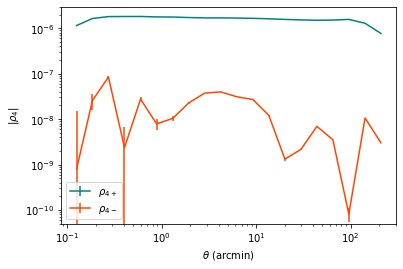

In [60]:
mplot.errorbar(theta, np.abs(rho5p), rho5p_err, color='teal', label='$ \\rho_{4+}$')
mplot.errorbar(theta, np.abs(rho5m), rho5m_err, color='orangered', label='$ \\rho_{4-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ |\\rho_{4}|$')
mplot.legend()

In [61]:
Alpha = []
Beta = []
Gamma = []
for i in range(20):
    A = np.array([[rho0p[i], rho2p[i], rho5p[i]], [rho2p[i], rho1p[i], rho4p[i]],[rho5p[i], rho4p[i], rho3p[i]]])
    B = np.array([tau0p[i], tau2p[i], tau5p[i]])
    X = np.linalg.solve(A, B)
    Alpha.append(X[0])
    Beta.append(X[1])
    Gamma.append(X[2])
    

(array([1., 0., 1., 2., 3., 4., 4., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 1.]),
 array([-0.00174396,  0.00067438,  0.00309272,  0.00551107,  0.00792941,
         0.01034776,  0.0127661 ,  0.01518444,  0.01760279,  0.02002113,
         0.02243947,  0.02485782,  0.02727616,  0.0296945 ,  0.03211285,
         0.03453119,  0.03694953,  0.03936788,  0.04178622,  0.04420456,
         0.04662291]),
 <BarContainer object of 20 artists>)

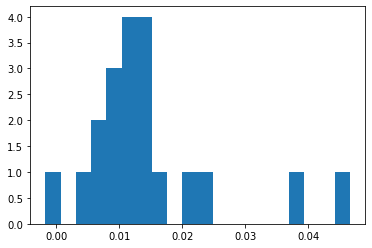

In [62]:
mplot.hist(Alpha, bins=20)

(array([1., 0., 0., 1., 2., 2., 2., 1., 4., 3., 2., 0., 1., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([-1.96852861, -1.72749732, -1.48646604, -1.24543475, -1.00440346,
        -0.76337217, -0.52234088, -0.2813096 , -0.04027831,  0.20075298,
         0.44178427,  0.68281556,  0.92384684,  1.16487813,  1.40590942,
         1.64694071,  1.887972  ,  2.12900329,  2.37003457,  2.61106586,
         2.85209715]),
 <BarContainer object of 20 artists>)

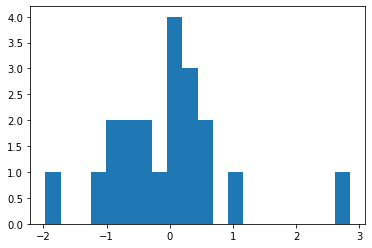

In [63]:
mplot.hist(Beta, bins=20)

(array([1., 0., 0., 3., 0., 1., 1., 1., 0., 3., 2., 1., 2., 1., 1., 1., 0.,
        0., 0., 2.]),
 array([-9.55677595, -8.20920762, -6.86163929, -5.51407096, -4.16650264,
        -2.81893431, -1.47136598, -0.12379765,  1.22377068,  2.57133901,
         3.91890733,  5.26647566,  6.61404399,  7.96161232,  9.30918065,
        10.65674897, 12.0043173 , 13.35188563, 14.69945396, 16.04702229,
        17.39459062]),
 <BarContainer object of 20 artists>)

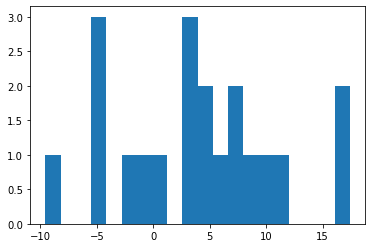

In [64]:
mplot.hist(Gamma, bins=20)

## Save everything

In [65]:
np.savez('Tau_Rho.npz', theta=theta, rho0p=rho0p, rho0p_err=rho0p_err, rho0m=rho0m, rho0m_err=rho0m_err, 
                                    rho1p=rho1p, rho1p_err=rho1p_err, rho1m=rho1m, rho1m_err=rho1m_err, 
                                    rho2p=rho2p, rho2p_err=rho2p_err, rho2m=rho2m, rho2m_err=rho2m_err, 
                                    rho3p=rho3p, rho3p_err=rho3p_err, rho3m=rho3m, rho3m_err=rho3m_err, 
                                    rho4p=rho4p, rho4p_err=rho4p_err, rho4m=rho4m, rho4m_err=rho4m_err, 
                                    rho5p=rho5p, rho5p_err=rho5p_err, rho5m=rho5m, rho5m_err=rho5m_err, 
                                    tau0p=tau0p, tau0p_err=tau0p_err, tau0m=tau0m, tau0m_err=tau0m_err, 
                                    tau2p=tau2p, tau2p_err=tau2p_err, tau2m=tau2m, tau2m_err=tau2m_err, 
                                    tau5p=tau5p, tau5p_err=tau5p_err, tau5m=tau5m, tau5m_err=tau5m_err)

In [ ]:
# need to update the tau stats using full covariance!